In [6]:
# Import需要的套件
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import time
import matplotlib.pyplot as plt
%matplotlib inline

#Read image
利用 OpenCV (cv2) 讀入照片並存放在 numpy array 中

In [7]:
def readfile(path, label):
    # label 是一個 boolean variable，代表需不需要回傳 y 值
    image_dir = sorted(os.listdir(path))
    x = np.zeros((len(image_dir), 128, 128, 3), dtype=np.uint8)
    y = np.zeros((len(image_dir)), dtype=np.uint8)
    for i, file in enumerate(image_dir):
        img = cv2.imread(os.path.join(path, file))
        x[i, :, :] = cv2.resize(img,(128, 128))
        if label:
          y[i] = int(file.split("_")[0])
    if label:
      return x, y
    else:
      return x

In [8]:
# 分別將 training set、validation set、testing set 用 readfile 函式讀進來
workspace_dir = './food-11'
print("Reading data")
train_x, train_y = readfile(os.path.join(workspace_dir, "training"), True)
print("Size of training data = {}".format(len(train_x)))
val_x, val_y = readfile(os.path.join(workspace_dir, "validation"), True)
print("Size of validation data = {}".format(len(val_x)))
test_x = readfile(os.path.join(workspace_dir, "testing"), False)
print("Size of Testing data = {}".format(len(test_x)))

Reading data
Size of training data = 9866
Size of validation data = 3430
Size of Testing data = 3347


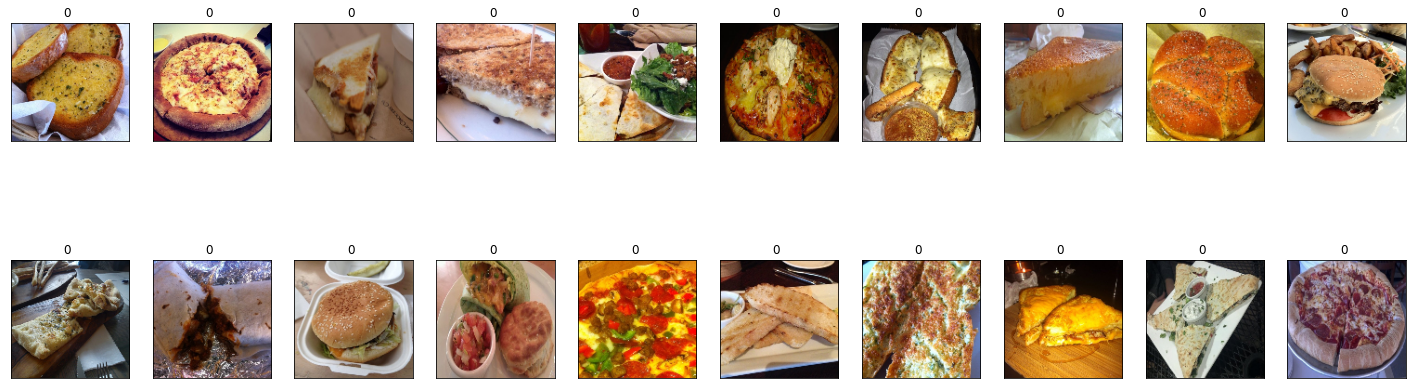

In [9]:
fig = plt.figure(figsize=(25, 8))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(cv2.cvtColor(train_x[idx], cv2.COLOR_BGR2RGB)) # 要做一下reverse
    ax.set_title("{} ".format( train_y[idx]))

# Dataset
在 PyTorch 中，我們可以利用 torch.utils.data 的 Dataset 及 DataLoader 來"包裝" data，使後續的 training 及 testing 更為方便。

Dataset 需要 overload 兩個函數：\_\_len\_\_ 及 \_\_getitem\_\_

\_\_len\_\_ 必須要回傳 dataset 的大小，而 \_\_getitem\_\_ 則定義了當程式利用 [ ] 取值時，dataset 應該要怎麼回傳資料。

實際上我們並不會直接使用到這兩個函數，但是使用 DataLoader 在 enumerate Dataset 時會使用到，沒有實做的話會在程式運行階段出現 error。


In [10]:
# training 時做 data augmentation
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(), # 隨機將圖片水平翻轉
    transforms.RandomRotation(15), # 隨機旋轉圖片
    transforms.ToTensor(), # 將圖片轉成 Tensor，並把數值 normalize 到 [0,1] (data normalization)
])
# testing 時不需做 data augmentation
test_transform = transforms.Compose([
    transforms.ToPILImage(),                                    
    transforms.ToTensor(),
])
class ImgDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.x = x
        # label is required to be a LongTensor
        self.y = y
        if y is not None:
            self.y = torch.LongTensor(y)
        self.transform = transform
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None:
            X = self.transform(X)
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else:
            return X

In [11]:
batch_size = 256
train_set = ImgDataset(train_x, train_y, train_transform)
val_set = ImgDataset(val_x, val_y, test_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# Model

In [12]:
droup_rate = 0.5

# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 3, stride = 1, padding = 1),  # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(128),
            #nn.Dropout(0.01),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            #nn.Dropout(0.01),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            #nn.Dropout(0.01),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]
            
            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
        )
        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(512*4*4, 512*4),
            nn.ReLU(),
            
            nn.Dropout(0.5),
            nn.Linear(512*4, 1024),
            nn.ReLU(),
            
            nn.Dropout(0.2),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            
            #nn.Linear(512*4*4, 1024),
            #nn.Dropout(0),
            #nn.ReLU(),
            
            nn.Linear(1024, 512),
            nn.ReLU(),
            
            nn.Linear(512, 11)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

# Training

使用 training set 訓練，並使用 validation set 尋找好的參數

In [13]:
torch.cuda.is_available()

True

In [ ]:
cuda1 = torch.device('cuda:0')

model = Classifier().cuda(cuda1)
loss = nn.CrossEntropyLoss() # 因為是 classification task，所以 loss 使用 CrossEntropyLoss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # optimizer 使用 Adam
num_epoch = 50
val_acc_set = []

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    model.train() # 確保 model 是在 train model (開啟 Dropout 等...)
    for i, data in enumerate(train_loader):
        optimizer.zero_grad() # 用 optimizer 將 model 參數的 gradient 歸零
        train_pred = model(data[0].cuda(cuda1)) # 利用 model 得到預測的機率分佈 這邊實際上就是去呼叫 model 的 forward 函數
        batch_loss = loss(train_pred, data[1].cuda(cuda1)) # 計算 loss （注意 prediction 跟 label 必須同時在 CPU 或是 GPU 上）
        batch_loss.backward() # 利用 back propagation 算出每個參數的 gradient
        optimizer.step() # 以 optimizer 用 gradient 更新參數值

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()
    
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            val_pred = model(data[0].cuda(cuda1))
            batch_loss = loss(val_pred, data[1].cuda(cuda1))

            val_acc += np.sum(np.argmax(val_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            val_acc_set.append(val_acc)
            val_loss += batch_loss.item()

        #將結果 print 出來
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
            (epoch + 1, num_epoch, time.time()-epoch_start_time, \
             train_acc/train_set.__len__(), train_loss/train_set.__len__(), val_acc/val_set.__len__(), val_loss/val_set.__len__()))
        

[001/050] 10.85 sec(s) Train Acc: 0.196635 Loss: 0.008921 | Val Acc: 0.145773 loss: 0.012011
[002/050] 10.75 sec(s) Train Acc: 0.280661 Loss: 0.007936 | Val Acc: 0.285423 loss: 0.007965
[003/050] 10.75 sec(s) Train Acc: 0.312386 Loss: 0.007649 | Val Acc: 0.281050 loss: 0.008568
[004/050] 10.57 sec(s) Train Acc: 0.351713 Loss: 0.007275 | Val Acc: 0.364140 loss: 0.007326
[005/050] 10.48 sec(s) Train Acc: 0.391445 Loss: 0.006920 | Val Acc: 0.321283 loss: 0.008205
[006/050] 10.50 sec(s) Train Acc: 0.410906 Loss: 0.006610 | Val Acc: 0.338484 loss: 0.007780
[007/050] 10.50 sec(s) Train Acc: 0.432495 Loss: 0.006418 | Val Acc: 0.367347 loss: 0.007657
[008/050] 10.55 sec(s) Train Acc: 0.463207 Loss: 0.006159 | Val Acc: 0.396210 loss: 0.007346
[009/050] 10.52 sec(s) Train Acc: 0.482566 Loss: 0.005896 | Val Acc: 0.465598 loss: 0.006225
[010/050] 10.53 sec(s) Train Acc: 0.499189 Loss: 0.005720 | Val Acc: 0.490087 loss: 0.005932
[011/050] 10.50 sec(s) Train Acc: 0.523312 Loss: 0.005434 | Val Acc: 0

得到好的參數後，我們使用 training set 和 validation set 共同訓練（資料量變多，模型效果較好）

In [10]:
train_val_x = np.concatenate((train_x, val_x), axis=0)
train_val_y = np.concatenate((train_y, val_y), axis=0)
train_val_set = ImgDataset(train_val_x, train_val_y, train_transform)
train_val_loader = DataLoader(train_val_set, batch_size=batch_size, shuffle=True)

In [11]:
model_best = Classifier().cuda()
loss = nn.CrossEntropyLoss() # 因為是 classification task，所以 loss 使用 CrossEntropyLoss
optimizer = torch.optim.Adam(model_best.parameters(), lr=0.001) # optimizer 使用 Adam
num_epoch = 400

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0

    model_best.train()
    for i, data in enumerate(train_val_loader):
        optimizer.zero_grad()
        train_pred = model_best(data[0].cuda())
        batch_loss = loss(train_pred, data[1].cuda())
        batch_loss.backward()
        optimizer.step()

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()

        #將結果 print 出來
    print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f' % \
      (epoch + 1, num_epoch, time.time()-epoch_start_time, \
      train_acc/train_val_set.__len__(), train_loss/train_val_set.__len__()))

[001/400] 12.69 sec(s) Train Acc: 0.223375 Loss: 0.008462
[002/400] 12.49 sec(s) Train Acc: 0.322052 Loss: 0.007478
[003/400] 12.47 sec(s) Train Acc: 0.369058 Loss: 0.006982
[004/400] 12.47 sec(s) Train Acc: 0.401173 Loss: 0.006643
[005/400] 12.50 sec(s) Train Acc: 0.427046 Loss: 0.006407
[006/400] 12.51 sec(s) Train Acc: 0.462094 Loss: 0.006036
[007/400] 12.47 sec(s) Train Acc: 0.490223 Loss: 0.005794
[008/400] 12.47 sec(s) Train Acc: 0.513162 Loss: 0.005485
[009/400] 12.48 sec(s) Train Acc: 0.531513 Loss: 0.005372
[010/400] 12.53 sec(s) Train Acc: 0.556859 Loss: 0.005106
[011/400] 12.53 sec(s) Train Acc: 0.583785 Loss: 0.004806
[012/400] 12.56 sec(s) Train Acc: 0.601986 Loss: 0.004549
[013/400] 12.53 sec(s) Train Acc: 0.617930 Loss: 0.004407
[014/400] 12.53 sec(s) Train Acc: 0.621691 Loss: 0.004337
[015/400] 12.53 sec(s) Train Acc: 0.641847 Loss: 0.004112
[016/400] 12.55 sec(s) Train Acc: 0.655385 Loss: 0.003965
[017/400] 12.54 sec(s) Train Acc: 0.671104 Loss: 0.003802
[018/400] 12.5

# Testing
利用剛剛 train 好的 model 進行 prediction

In [ ]:
test_set = ImgDataset(test_x, transform=test_transform)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [ ]:
model_best.eval()
prediction = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        test_pred = model_best(data.cuda())
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        for y in test_label:
            prediction.append(y)

In [ ]:
#將結果寫入 csv 檔
with open("best_predict.csv", 'w') as f:
    f.write('Id,Category\n')
    for i, y in  enumerate(prediction):
        f.write('{},{}\n'.format(i, y))

In [ ]:
torch.save(model_best, 'model_best.pkl')

In [ ]:
model_best=torch.load('model_best.pkl')